In [139]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# Importing some plumbing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Importing the models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
#from stats import zscore

### Let's load in the data and poke around.

In [117]:
energy_df = pd.read_csv('recs2009_public.csv')
energy_df.head()


C:\Users\User\AppData\Local\Temp\ipykernel_11148\3006714245.py:1: DtypeWarning: Columns (717,718) have mixed types. Specify dtype option on import or set low_memory=False.
  energy_df = pd.read_csv('recs2009_public.csv')


,DOEID,REGIONC,DIVISION,REPORTABLE_DOMAIN,TYPEHUQ,NWEIGHT,HDD65,CDD65,HDD30YR,CDD30YR,...,SCALEKER,IECC_Climate_Pub,HDD50,CDD80,GND_HDD65,WSF,OA_LAT,GWT,DesignDBT99,DesignDBT1
0,1,2,4,12,2,2471.68,4742,1080,4953,1271,...,-2,4A,2117,56,4250,0.48,6,56,9,96
1,2,4,10,26,2,8599.17,2662,199,2688,143,...,-2,3C,62,26,2393,0.61,0,64,38,73
2,3,1,1,1,5,8969.92,6233,505,5741,829,...,-2,5A,2346,49,5654,0.48,3,52,12,88
3,4,2,3,7,2,18003.64,6034,672,5781,868,...,-2,5A,2746,0,4941,0.55,4,55,7,87
4,5,1,1,1,3,5999.61,5388,702,5313,797,...,-2,5A,2251,0,5426,0.61,4,50,13,90


Alright, I immediately notice there's nearly a thousand columns. I doubt they're all relevant, so let's find a way of whittling them down.

### Upfront feature removal.

Right off the bat, we can remove certain features based on the values in the columns or the correlation between feature columns.  

I can't help but notice, for example, that certain columns like `SCALEKER` consist almost entirely of the value `-2`:

In [118]:
energy_df['SCALEKER'].unique()

array([-2,  3,  0], dtype=int64)

In [119]:
energy_df['SCALEKER'].value_counts()

-2    11917
 0       97
 3       69
Name: SCALEKER, dtype: int64

Though I couldn't be *100%* sure that this column has no predictive value without some more testing, for the purposes of a takehome I'm comfortable making the simplifying assumption that this feature contains little of value. I'll drop it and any columns like it.

In [120]:
homogenous_columns = [col for col in energy_df if (energy_df[col].value_counts(normalize=True).max() > 0.95)]
len(homogenous_columns)

484

In [121]:
energy_df.drop(labels=homogenous_columns, axis=1, inplace=True)

# What are we left with? This operation cuts our columns in half.
print(len(energy_df.columns))

456


I gather from the codebook that certain columns contain information which is connected in some way to the target variable. We want to predict `KWH`, and `KWHSPH` contains the subset of `KWH` which was contributed by space heaters. Similarly, `BTUELSPH` contains the exact same data, but expressed it British Thermal Units instead of kilowatt-hours. 


We can't include these or similar columns because, in effect, this would be tantamount to allowing the model to 'peak' at the target variable. They've all got to go.

As far as I can tell the column-naming scheme is pretty consistent, so we can do this pretty straightforwardly with a list comprehension that does simple checking on the column names. 

In [122]:
redundant_kwh_columns = [col for col in energy_df.columns if ("KWH" in col and len(col)> 3)]
redundant_btu_columns = [col for col in energy_df.columns if ("BTUEL" in col and len(col)> 3)]

redundant_columns = redundant_kwh_columns + redundant_btu_columns
# redundant_columns

energy_df.drop(columns=redundant_columns, inplace=True)

Let's make sure these columns are actually gone. We could print them out:

```
for col in energy_df.columns:
    print(col)
```

But a simpler solution is to just check to see if the `redundant_columns` list is a subset of the total columns.

In [123]:
set(redundant_columns).issubset(set(energy_df.columns))

False

In my first run-through the model achieved an accuracy of 99.9%, which makes me suspicious. I decided to go back and remove any highly-correlated columns. 

In [124]:
cor_matrix = energy_df.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(bool))
correlated_columns = [col for col in upper_tri.columns if any(upper_tri[col] > 0.85)]

correlated_columns[:5] # Just to get a sample

['DIVISION', 'REPORTABLE_DOMAIN', 'HDD30YR', 'CDD30YR', 'YEARMADERANGE']

In [125]:
energy_df.drop(columns=correlated_columns , inplace=True)

<AxesSubplot: >

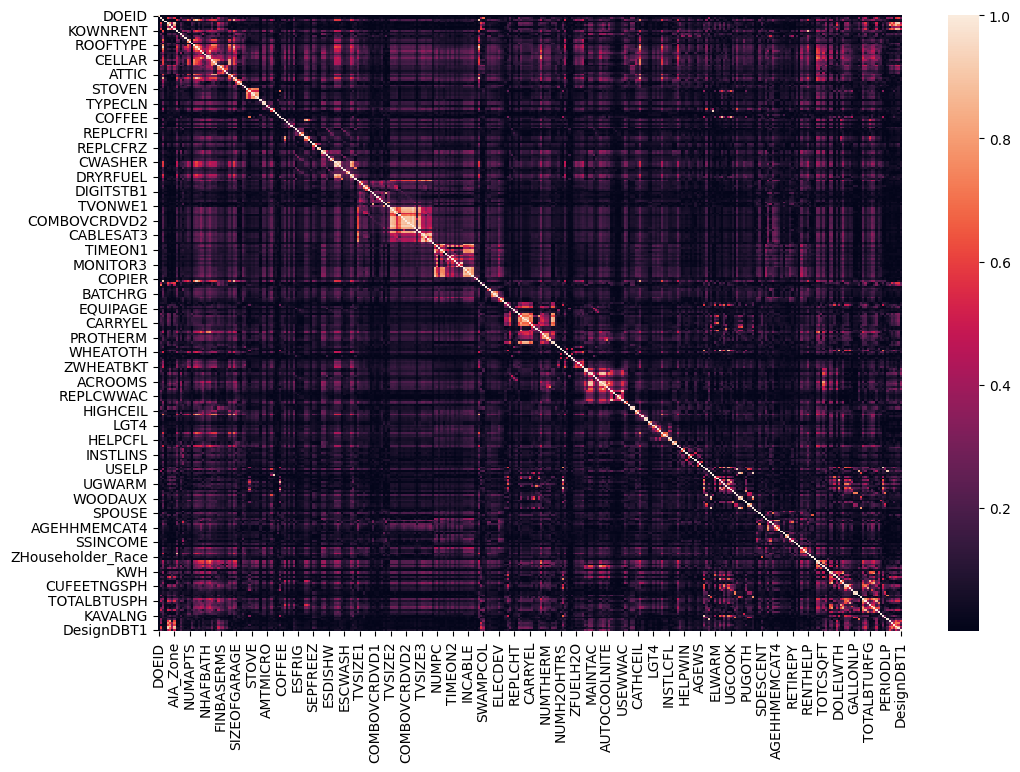

In [140]:
# Let's plot the correlation matrix after we drop the really correlated columns.

plt.figure(figsize=(12,8))
sns.heatmap(energy_df.corr().abs())

There are so many columns here it's hard to tell much visually, but given that the colors are generally darker I'd say we've done a reasonably good job of removing correlations and reducing the problems associated with multicollinearity.

### Feature scaling

It's well-known that features need to be scaled to work properly for a regression model. 

There can be a little subtlety to this--you've got to be careful whether and under what circumstances you standardize a categorical variable, for example, and different techniques exist for scaling e.g. ordinal v.s. cardinal features.

For the sake of simplicity I just elided all this by dropping any categorical column and scaling what was left.

In [126]:
## By poking around in the output of energy_df.info(verbose=True) I found a few categorical columns that need to be dropped before scaling can happen.
cat_cols = ['METROMICRO', 'UR', 'NOCRCASH', 'NKRGALNC', 'IECC_Climate_Pub']

energy_df.drop(columns=cat_cols, inplace=True)

### Train test splitting and fitting a model

With the column suitably whittled down, let's fit a few models and see what we get.

In [127]:
X = energy_df.drop('KWH', axis=1).values
y = energy_df['KWH'].values

In [128]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [129]:
# Now to scale the features

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

##### A simple linear regression

In [130]:
linreg = LinearRegression()
linreg.fit(X_train_std, y_train)

LinearRegression()

In [131]:
# How'd the model do?

linreg.score(X_test_std, y_test)

0.9907031601850084

##### A simple decision tree regressor

In [132]:
treereg = DecisionTreeRegressor()
treereg.fit(X_train_std, y_train)

DecisionTreeRegressor()

In [133]:
treereg.score(X_test_std, y_test)

0.8799602718276105

##### A simple KNN regressor

In [136]:
knnreg = KNeighborsRegressor()
knnreg.fit(X_train_std, y_train)

KNeighborsRegressor()

In [137]:
knnreg.score(X_test_std, y_test)

0.6306357277857453

### Next Steps

### Advanced feature engineering

There were too many columns and too many little subtleties for me to spend much time on this, but ideally there are a few things you'd want to check.

#### Multicollinearity and correlation

#### standardization, PCA, and feature reduction

I chose not to do this because I'd need to get into the columns and figure out what needs to one-hot encoded, where standardization would be a problem (i.e. on categorical features), etc. before I can do proper PCA. 